In [1]:
cd ../analysis/

/home/jlee782/final_segmentation/analysis


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


```
[jlee782@hilda analysis]$ ls pixel_em/5workers_rand0/obj1/hybrid/
100/ 500/
[jlee782@hilda analysis]$ ls pixel_em/5workers_rand0/obj1/hybrid/100/\(0.
(0.6,0.4)/   (0.65,0.35)/ (0.7,0.3)/   (0.75,0.25)/ (0.8,0.2)/   (0.85,0.15)/ (0.9,0.1)/   (0.95,0.05)/
```

In [3]:
from ast import literal_eval as make_tuple
from utils import * 
ec_threshs = [(0.6,0.4),(0.65)]
from sample_worker_seeds import sample_specs
sample_lst = sample_specs.keys()
obj_clusters = clusters()
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]

/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
import glob

In [21]:
base="MV"
df_data=[]
for k in range(100,550,50):
    for objid in object_lst: #range(1, 2):
        for batch in sample_lst:
            if str(objid) in obj_clusters[batch]:
                clusts = ["-1"] + [obj_clusters[batch][str(objid)]]
            else:
                clusts = ["-1"]
            for clust in clusts:
                hydir = '{}{}/obj{}/hybrid/{}/'.format(PIXEL_EM_DIR, batch, objid, k)
                #print hydir
                for ecglobpath in glob.glob(hydir+"/*"):
                    expand_thresh, contract_thresh = make_tuple(ecglobpath.split("/")[-1])
                    hybriddir = hybrid_dir(batch, objid, k, expand_thresh, contract_thresh)
                    prj_file = hybriddir+"/{}_{}_hybrid_prj.json".format(base,clust)
                    if os.path.exists(prj_file):
                        p,r,j = json.load(open(prj_file))
                    df_data.append([batch, objid,clust, k, expand_thresh, contract_thresh,p,r,j])

In [22]:
df = pd.DataFrame(df_data,columns=["sample","objid","clust","k","expand_thresh","contract_thresh","p","r","j"])

In [23]:
df[df["sample"]=="5workers_rand0"]

,sample,objid,clust,k,expand_thresh,contract_thresh,p,r,j
30,5workers_rand0,1,-1,100,0.6,0.4,0.985052,0.963909,0.950013
31,5workers_rand0,1,-1,100,0.8,0.2,0.982874,0.970975,0.954820
32,5workers_rand0,1,-1,100,0.9,0.1,0.978363,0.980866,0.960040
33,5workers_rand0,1,-1,100,0.7,0.3,0.984272,0.965551,0.950880
34,5workers_rand0,1,0,100,0.6,0.4,0.983630,0.966086,0.950799
35,5workers_rand0,1,0,100,0.8,0.2,0.983630,0.966086,0.950799
36,5workers_rand0,1,0,100,0.9,0.1,0.983630,0.966086,0.950799
37,5workers_rand0,1,0,100,0.7,0.3,0.983630,0.966086,0.950799
86,5workers_rand0,2,-1,100,0.6,0.4,0.963731,0.969665,0.935526
87,5workers_rand0,2,-1,100,0.8,0.2,0.962753,0.970416,0.935302


In [32]:
ls pixel_em/25workers_rand0/obj1/hybrid/100/\(0.6,0.4\)/*

pixel_em/25workers_rand0/obj1/hybrid/100/(0.6,0.4)/MV_-1_hybrid_mask.pkl
pixel_em/25workers_rand0/obj1/hybrid/100/(0.6,0.4)/MV_-1_hybrid_mask.png
pixel_em/25workers_rand0/obj1/hybrid/100/(0.6,0.4)/MV_-1_hybrid_prj.json


In [41]:
import pickle as pkl
mask = pkl.load(open("pixel_em/25workers_rand0/obj1/hybrid/100/(0.6,0.4)/MV_-1_hybrid_mask.pkl"))

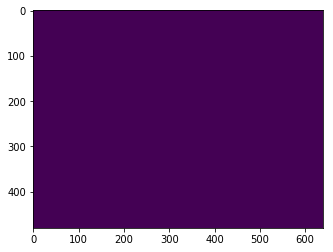

In [43]:
plt.imshow(mask)